Cleaning + adding attributes from GeoData

In [5]:
#---------------------------- SETUP ---------------------------

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

#load main dataset
df_original = pd.read_csv('../data/Access_to_Everyday_Life_Dataset.csv') #keep a copy of the original column names to make sure we dont lose anything later ?
original_columns = df_original.columns.tolist()
initial_count = len(df_original)

print(f"main dataset has {initial_count:} rows")
print(f"original columns has length {len(original_columns)}: {original_columns}")

#load seattle geodata dataset
equity_url = "../data/Race_and_Social_Equity_Composite_Index_Current_-7412683458374933434.geojson"
try:
    gdf_census = gpd.read_file(equity_url)
    print(f"loaded {len(gdf_census)} tracts")
except Exception as e:
    print(f"error loading geodata data: {e}")
    raise

main dataset has 81973 rows
original columns has length 9: ['type', 'geometry/type', 'geometry/coordinates/0', 'geometry/coordinates/1', 'properties/attribute_id', 'properties/label_type', 'properties/neighborhood', 'properties/severity', 'properties/is_temporary']
loaded 179 tracts


In [8]:
#---------------------------- CLEANING ---------------------------
#for spatial join
geometry = [Point(xy) for xy in zip(df_original['geometry/coordinates/0'], df_original['geometry/coordinates/1'])]
gdf_sidewalk = gpd.GeoDataFrame(df_original, geometry=geometry, crs="EPSG:4326")

#check
missing_severity_count = gdf_sidewalk['properties/severity'].isna().sum()
print(f"rows with missing severity: {missing_severity_count}")

#assign missing severity. 'Occlusion' = 3, others = median for that type
severity_map = {'CurbRamp': 1, 'NoCurbRamp': 3, 'NoSidewalk': 4, 'Obstacle': 3, 'SurfaceProblem': 3, 'Other': 3, 'Occlusion': 3}
gdf_sidewalk['properties/severity'] = gdf_sidewalk['properties/severity'].fillna(gdf_sidewalk['properties/label_type'].map(severity_map))

#spatial join & enrichment
if gdf_census.crs != gdf_sidewalk.crs: #ensure coord systems match
    gdf_census = gdf_census.to_crs(gdf_sidewalk.crs)

joined_df = gpd.sjoin(gdf_sidewalk, gdf_census, how="inner", predicate="within") #points outside the city (invalid locations, water) will be dropped automatically

dropped_count = initial_count - len(joined_df)
print(f"dropped invalid rows: {dropped_count:}")


rows with missing severity: 2251
dropped invalid rows: 50


In [10]:
#---------------------------- FINAL COLUMNS ---------------------------
#combine original columns + new ones
#the join added a lot of extra geodata columns we dont need, so we filter them out here

new_columns_to_add = [
    'GEOID', #tract ID
    'PCT_ENGLISH_LANG_LEARNERS', #limited english
    'PCT_POP_UNDER200PCT_POVERTY', #low income
    'PCT_ADULT_WITH_DISABILITY' #disabled
]

final_columns = original_columns + new_columns_to_add
final_df = joined_df[final_columns].copy() #create final clean dataframe
final_df = final_df.rename(columns={
    'GEOID': 'Census_Tract_ID',
    'PCT_ENGLISH_LANG_LEARNERS': 'Pct_Limited_English',
    'PCT_POP_UNDER200PCT_POVERTY': 'Pct_Low_Income',
    'PCT_ADULT_WITH_DISABILITY': 'Pct_Disability'
})

print(f"final row count: {len(final_df):}")
print(f"columns preserved: {len(original_columns)}")
print(f"columns added: {len(new_columns_to_add)}")

print("PREVIEW (last 5 columns are the new ones):")
print(final_df.iloc[:, -6:].head().to_markdown(index=False))

#save
final_df.to_csv('Seattle_Mobility_Enriched_Full.csv', index=False)

final row count: 81923
columns preserved: 9
columns added: 4
PREVIEW (last 5 columns are the new ones):
|   properties/severity | properties/is_temporary   |   Census_Tract_ID |   Pct_Limited_English |   Pct_Low_Income |   Pct_Disability |
|----------------------:|:--------------------------|------------------:|----------------------:|-----------------:|-----------------:|
|                     4 | False                     |       53033008900 |                0.1268 |           0.1418 |        0.0726549 |
|                     3 | False                     |       53033008900 |                0.1268 |           0.1418 |        0.0726549 |
|                     4 | False                     |       53033008900 |                0.1268 |           0.1418 |        0.0726549 |
|                     4 | False                     |       53033008900 |                0.1268 |           0.1418 |        0.0726549 |
|                     4 | False                     |       53033009000 |       

Doing a correlation matrix between disability, low income, limited english, and severity

Severity from properties/severity
Disability from Pct_Disability
Low Income from Pct_Low_Income
Limited English from Pct_Limited_English


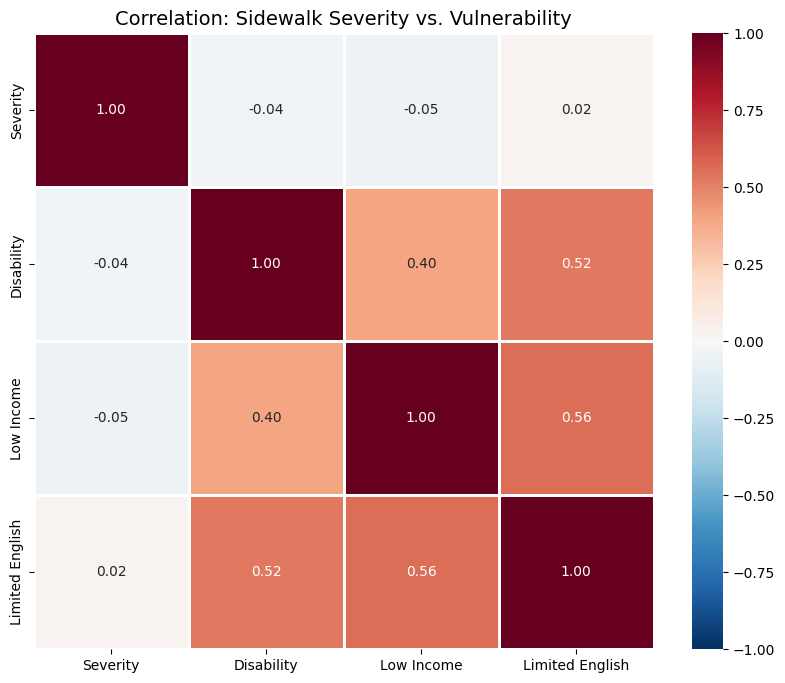

                 Severity  Disability  Low Income  Limited English
Severity         1.000000   -0.037112   -0.049838         0.023622
Disability      -0.037112    1.000000    0.395343         0.523793
Low Income      -0.049838    0.395343    1.000000         0.555461
Limited English  0.023622    0.523793    0.555461         1.000000


In [12]:
#---------------------------- SETUP ---------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#load new enriched dataset
filename = '../data/Seattle_Mobility_Enriched_Full.csv'
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"error finding {filename}")

column_mapping = {
    'Severity': 'properties/severity',
    'Disability': 'Pct_Disability',
    'Low Income': 'Pct_Low_Income',
    'Limited English': 'Pct_Limited_English'
}

#create a subset dataframe with just these columns
analysis_data = pd.DataFrame()

for label, col_name in column_mapping.items():
    if col_name in df.columns:
        analysis_data[label] = df[col_name]
        print(f"{label} from {col_name}")
    else:
        print(f"error {col_name}")

#generate correlation matrix
corr_matrix = analysis_data.corr()

#plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True, #show numbers
    cmap='RdBu_r',
    center=0,
    fmt=".2f", #2 decimal places
    linewidths=1,
    vmin=-1, vmax=1
)
plt.title('Correlation: Sidewalk Severity vs. Vulnerability', fontsize=14)
plt.show()
print(corr_matrix)